#### **Persistence in LangGraph**

- Once a workflow execution finishes
- The **state data is erased**
- Starting a new workflow run begins with a **fresh state**

This behavior is ideal for **stateless executions**, but not sufficient when
we want memory, recovery, or long-running workflows.

---

## ❓ What is Persistence?

**Persistence in LangGraph** refers to the ability to:

- ✅ **Save** the workflow state
- ✅ **Restore** the state at a later time
- ✅ Resume execution from a previous checkpoint

> Persistence allows workflows to survive beyond a single execution.
It not only stores state at final stage but also at intermediate stages

---

### **checkpointer** in Persistence

We used to create checkpoints at each level or supersteps and store the state.

<p align="center">
  <img src="/Users/umesh/Desktop/LangGraph-AI-Agents-/images/checkpointers.png" width="500"/>
</p>

### **threads** in Persistence

To differentiate between 2 or more unique runs of a workflow we assign a **thread_id** to them.

The checkpointer values will be stored corresponding to the thread_id, so that we can retrieve state of a particular run

### **Practice Workflow**

We'll make a workflow adding **Persistence**
- Start with a topic 
- LLM will generate a joke on the topic 
- LLM will generate explaination of joke 
- Workflow ends 

Implement the persistence with checkpointers and threads

<p align="center">
  <img src="/Users/umesh/Desktop/LangGraph-AI-Agents-/images/praticing_persistence.png" width="200" height="400"/>
</p>

In [4]:
# llm used - 'llama3.2'
from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0.2
)

llm.invoke("Hey How are you?")

AIMessage(content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to help with any questions or tasks you may have! How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-09T17:25:13.464936Z', 'done': True, 'done_reason': 'stop', 'total_duration': 19576617959, 'load_duration': 1603771250, 'prompt_eval_count': 30, 'prompt_eval_duration': 14762331000, 'eval_count': 46, 'eval_duration': 3206294250, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019ba3ca-29ce-74f2-bf8e-c8a02547b7af-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 30, 'output_tokens': 46, 'total_tokens': 76})

In [ ]:
from langgraph.graph import StateGraph, START, END 
from typing import TypedDict, Annotated
from langgraph.checkpoint.memory import InMemorySaver # stores in RAM

In [20]:
class JokeState(TypedDict):
    """ 
    This is the shared and mutable state while executing the flow.
    """
    topic: str
    joke: str
    explaination: str

In [14]:
from langchain_core.prompts import PromptTemplate

def generate_joke(state: JokeState) -> JokeState:
    template = """
                You are a helpful assistant. Given a topic : {topic}.
                Generate a short joke related to this topic. 
               """

    prompt = PromptTemplate(
        template=template,
        input_variables=['topic']
    )

    chain = prompt | llm 
    response = chain.invoke({'topic' : state['topic']})
    return {
        'joke' : response.content
    }

def describe_joke(state: JokeState) -> JokeState:
    template = """
                You are a helpful assistant. Given a joke : {joke}.
                You need to describe this joke. 
               """

    prompt = PromptTemplate(
        template=template,
        input_variables=['joke']
    )

    chain = prompt | llm 
    response = chain.invoke({'joke' : state['joke']})
    return {
        'explaination' : response.content
    }    

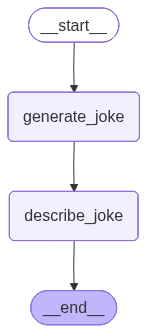

In [21]:
# graph 
graph = StateGraph(JokeState)

# adding nodes 
graph.add_node('generate_joke', generate_joke)
graph.add_node('describe_joke', describe_joke)

# adding edges 
graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'describe_joke')
graph.add_edge('describe_joke', END)

# Checkpointer 
checkpointer = InMemorySaver()

# compile graph 
joke_flow = graph.compile(checkpointer=checkpointer)

# dispaly grpah 
from IPython.display import Image
Image(joke_flow.get_graph().draw_mermaid_png())

In [22]:
input_state = {'topic' : 'dog'}
config = {'configurable' : {'thread_id' : "1"}}
output_state = joke_flow.invoke(input_state, config=config)

from pprint import pprint
pprint(output_state)

{'explaination': 'This is a classic play on words!\n'
                 '\n'
                 'The joke starts by setting up a question: "Why did the dog '
                 'go to the vet?" The listener expects a typical reason, such '
                 "as because it's sick or hurt.\n"
                 '\n'
                 'But then comes the punchline: "Because he was feeling ruff!" '
                 'Here\'s where the wordplay kicks in. In this context, "ruff" '
                 'has a double meaning:\n'
                 '\n'
                 '1. Dogs are known for making loud barking sounds, which is '
                 'called "ruffing."\n'
                 '2. Feeling "ruff" can also mean feeling unwell or sick.\n'
                 '\n'
                 'So, the joke is saying that the dog went to the vet because '
                 'it was feeling unwell (sick), but the word "ruff" has a '
                 'clever connection to the fact that dogs make loud barking '
              

In [23]:
# to see what's inside config with different thread_id 
joke_flow.get_state(config=config)

StateSnapshot(values={'topic': 'dog', 'joke': 'Why did the dog go to the vet?\n\nBecause he was feeling ruff!', 'explaination': 'This is a classic play on words!\n\nThe joke starts by setting up a question: "Why did the dog go to the vet?" The listener expects a typical reason, such as because it\'s sick or hurt.\n\nBut then comes the punchline: "Because he was feeling ruff!" Here\'s where the wordplay kicks in. In this context, "ruff" has a double meaning:\n\n1. Dogs are known for making loud barking sounds, which is called "ruffing."\n2. Feeling "ruff" can also mean feeling unwell or sick.\n\nSo, the joke is saying that the dog went to the vet because it was feeling unwell (sick), but the word "ruff" has a clever connection to the fact that dogs make loud barking sounds. It\'s a lighthearted and silly pun that creates humor!'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed832-832a-6ea2-8002-5a00b122a219'}}, metadata={'source': 'loop'

In [24]:
# to get intermediate state 
list(joke_flow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'dog', 'joke': 'Why did the dog go to the vet?\n\nBecause he was feeling ruff!', 'explaination': 'This is a classic play on words!\n\nThe joke starts by setting up a question: "Why did the dog go to the vet?" The listener expects a typical reason, such as because it\'s sick or hurt.\n\nBut then comes the punchline: "Because he was feeling ruff!" Here\'s where the wordplay kicks in. In this context, "ruff" has a double meaning:\n\n1. Dogs are known for making loud barking sounds, which is called "ruffing."\n2. Feeling "ruff" can also mean feeling unwell or sick.\n\nSo, the joke is saying that the dog went to the vet because it was feeling unwell (sick), but the word "ruff" has a clever connection to the fact that dogs make loud barking sounds. It\'s a lighthearted and silly pun that creates humor!'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0ed832-832a-6ea2-8002-5a00b122a219'}}, metadata={'source': 'loop